In [13]:
# this is to fix the error of NotImplementedError: The operator 'aten::_linalg_det.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS."
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch
import gc
import imageio
import yaml
from torch.optim import Adam
from datetime import datetime
from PIL import Image
import requests

## 2D Gaussian Splatting ##

The core function for generating 2D Gaussian Splatting. The core mechanic of this function is as follow

> Constructs a 2D Gaussian kernel using ~~provided batch of sigma_x, sigma_y, and rho~~ rotation and scale \
(as proposed in the [3D Gaussian Splatting paper](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/3d_gaussian_splatting_low.pdf), to constrain the 2D Gaussian to valid covariance matrices we describle the 2D Gaussian in a form of an ellipse with rotation and scale)
\begin{equation} \Sigma = RS^TR^T \end{equation}


> Normalises and reshapes the kernel to RGB channels, pads to match the image size, and translates based on given coords. Basically poutting the relevant kernel in the relevant coordinate position.


> Multiplies the RGB kernels with given colours, sums up the layers, and returns the final clamped and permuted image.







In [15]:
def generate_2D_gaussian_splatting(kernel_size, scale, rotation, coords, colours, image_size=(256, 256, 3), device="cpu"):
    batch_size = colours.shape[0]

    # Ensure scale and rotation have the correct shape
    scale = scale.view(batch_size, 2)
    rotation = rotation.view(batch_size)

    # Compute the components of the covariance matrix
    cos_rot = torch.cos(rotation)
    sin_rot = torch.sin(rotation)

    R = torch.stack([
        torch.stack([cos_rot, -sin_rot], dim=-1),
        torch.stack([sin_rot, cos_rot], dim=-1)
    ], dim=-2)

    S = torch.diag_embed(scale)

    # Compute covariance matrix: RSS^TR^T
    covariance = R @ S @ S @ R.transpose(-1, -2)

    # Compute inverse covariance
    inv_covariance = torch.inverse(covariance)

    # Create the kernel
    x = torch.linspace(-5, 5, kernel_size, device=device)
    y = torch.linspace(-5, 5, kernel_size, device=device)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([xx, yy], dim=-1).unsqueeze(0).expand(batch_size, -1, -1, -1)

    z = torch.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)
    kernel = torch.exp(z) / (2 * torch.tensor(np.pi, device=device) * torch.sqrt(torch.det(covariance))).view(batch_size, 1, 1)

    # Normalize the kernel
    kernel_max = kernel.amax(dim=(-2, -1), keepdim=True)
    kernel_normalized = kernel / kernel_max

    # Reshape the kernel for RGB channels
    kernel_rgb = kernel_normalized.unsqueeze(1).expand(-1, 3, -1, -1)

    # Add padding to match image size
    pad_h = image_size[0] - kernel_size
    pad_w = image_size[1] - kernel_size

    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")

    padding = (pad_w // 2, pad_w // 2 + pad_w % 2, pad_h // 2, pad_h // 2 + pad_h % 2)
    kernel_rgb_padded = F.pad(kernel_rgb, padding, "constant", 0)

    # Translate the kernel
    b, c, h, w = kernel_rgb_padded.shape
    theta = torch.zeros(b, 2, 3, dtype=torch.float32, device=device)
    theta[:, 0, 0] = 1.0
    theta[:, 1, 1] = 1.0
    theta[:, :, 2] = coords

    grid = F.affine_grid(theta, size=(b, c, h, w), align_corners=True)
    kernel_rgb_padded_translated = F.grid_sample(kernel_rgb_padded, grid, align_corners=True)

    # Apply colors and sum the layers
    rgb_values_reshaped = colours.unsqueeze(-1).unsqueeze(-1)
    final_image_layers = rgb_values_reshaped * kernel_rgb_padded_translated
    final_image = final_image_layers.sum(dim=0)
    final_image = torch.clamp(final_image, 0, 1)
    final_image = final_image.permute(1, 2, 0)

    return final_image

# Example usage

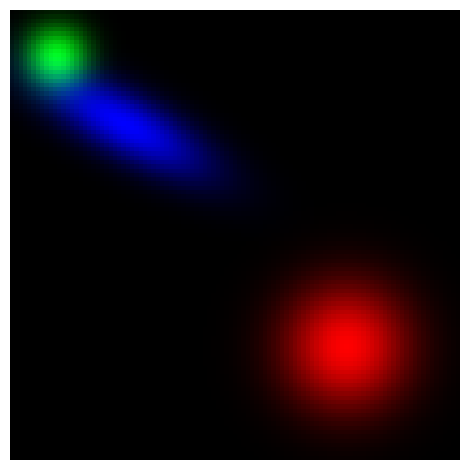

In [16]:
device = "mps"
kernel_size = 101  # You can adjust the kernel size as needed

scale_x = torch.tensor([1.0, 0.5, 0.5], device=device)
scale_y = torch.tensor([1.0, 0.5, 1.5], device=device)
scale = torch.stack([scale_x, scale_y], dim=-1)
rotation = torch.tensor([0.0, 0.0, -0.5], device=device) # a value between -pi/2 and pi/2
vectors = torch.tensor([(-0.5, -0.5), (0.8, 0.8), (0.5, 0.5)], device=device)
colours = torch.tensor([(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0)], device=device)
img_size = (105, 105, 3)

final_image = generate_2D_gaussian_splatting(kernel_size, scale, rotation, vectors, colours, img_size, device=device)

plt.imshow(final_image.detach().cpu().numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

## Structural Similarity Index (SSIM) ##
This function calculates the combined loss by taking the weighted sum of L1 (mean absolute error) loss and the SSIM-based loss, controlled by lambda_param. This approach might be used to balance the importance of pixel-level accuracy (L1) and perceptual quality (SSIM) in the training of neural networks.

In [17]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)]))
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.autograd.Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window



def ssim(img1, img2, window_size=11, size_average=True):

    (_, _, channel) = img1.size()

    img1 = img1.unsqueeze(0).permute(0, 3, 1, 2)
    img2 = img2.unsqueeze(0).permute(0, 3, 1, 2)


    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    SSIM_numerator = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))
    SSIM_denominator = ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    SSIM = SSIM_numerator / SSIM_denominator

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    l1loss = nn.L1Loss()
    return (1 - lambda_param) * l1loss(pred, target) + lambda_param * d_ssim_loss(pred, target)

## Load Config ##

In [18]:
KERNEL_SIZE = 101
image_size = [256, 256, 3]
primary_samples = 1000
backup_samples = 1000
num_epochs = 1001
densification_interval = 300
learning_rate = 0.01
image_file_name = "image.png"
display_interval = 100
gradient_threshold = 0.002
gaussian_threshold = 0.75
display_loss = True

## Prepate the points ##

In [19]:
def give_required_data(input_coords, image_size):

  # normalising pixel coordinates [-1,1]
  coords = torch.tensor(input_coords / [image_size[0],image_size[1]], device=device, dtype=torch.float32)
  center_coords_normalized = torch.tensor([0.5, 0.5], device=device, dtype=torch.float32)
  coords = (center_coords_normalized - coords) * 2.0

  # Fetching the colour of the pixels in each coordinates
  colour_values = [image_array[coord[1], coord[0]] for coord in input_coords]
  colour_values_np = np.array(colour_values)
  colour_values_tensor =  torch.tensor(colour_values_np, device=device, dtype=torch.float32)

  return colour_values_tensor, coords

In [23]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
num_samples = primary_samples + backup_samples

PADDING = KERNEL_SIZE // 2
image_path = image_file_name
original_image = Image.open(image_path)
original_image = original_image.resize((image_size[0],image_size[0]))
original_image = original_image.convert('RGB')
original_array = np.array(original_image)
original_array = original_array / 255.0
width, height, _ = original_array.shape

image_array = original_array
target_tensor = torch.tensor(image_array, dtype=torch.float32, device=device)
coords = np.random.randint(0, [width, height], size=(num_samples, 2), dtype=np.int32)
random_pixel_means = torch.tensor(coords, device=device, dtype=torch.float32)
pixels = [image_array[coord[0], coord[1]] for coord in coords]
pixels_np = np.array(pixels)
random_pixels =  torch.tensor(pixels_np, device=device, dtype=torch.float32)

colour_values, pixel_coords = give_required_data(coords, image_size)

colour_values = torch.logit(colour_values)
pixel_coords = torch.atanh(pixel_coords)

scale_values = torch.logit(torch.rand(num_samples, 2, device=device))
rotation_values = torch.atanh(2 * torch.rand(num_samples, 1, device=device) - 1)
alpha_values = torch.logit(torch.rand(num_samples, 1, device=device))
W_values = torch.cat([scale_values, rotation_values, alpha_values, colour_values, pixel_coords], dim=1)


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [10]:
starting_size = primary_samples
left_over_size = backup_samples
persistent_mask = torch.cat([torch.ones(starting_size, dtype=bool),torch.zeros(left_over_size, dtype=bool)], dim=0)
current_marker = starting_size

In [11]:
W = nn.Parameter(W_values)
optimizer = Adam([W], lr=learning_rate)
loss_history = []

## Training Loop ##

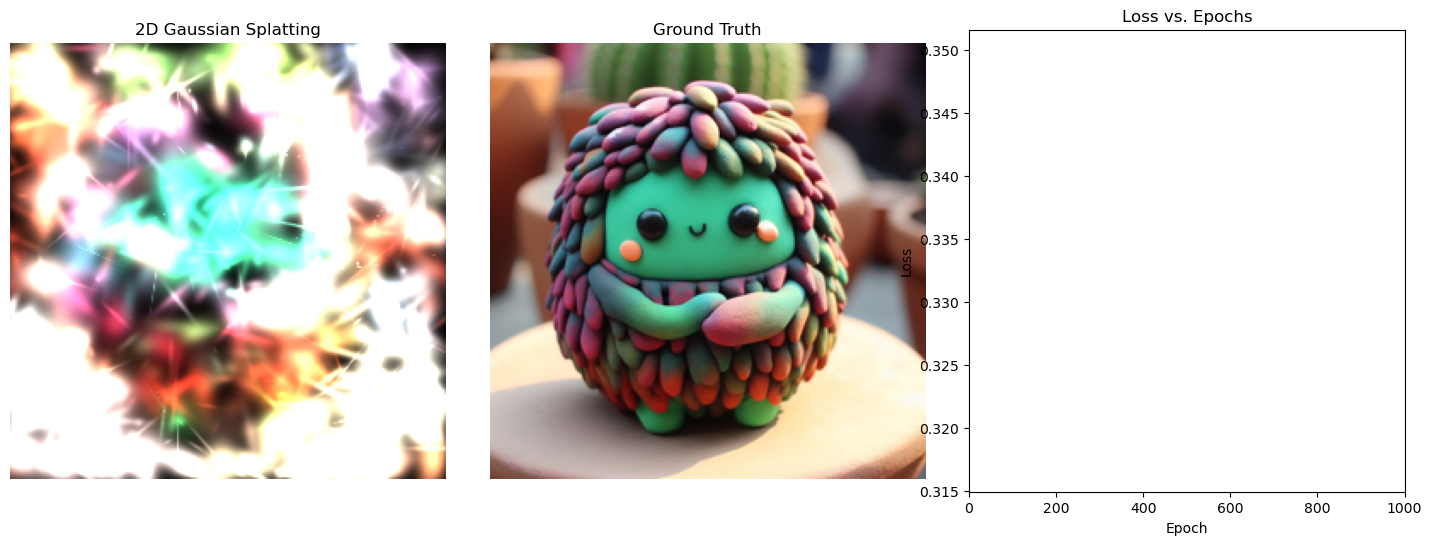

Epoch 1/1001, Loss: 0.33328190445899963, on 1000 points


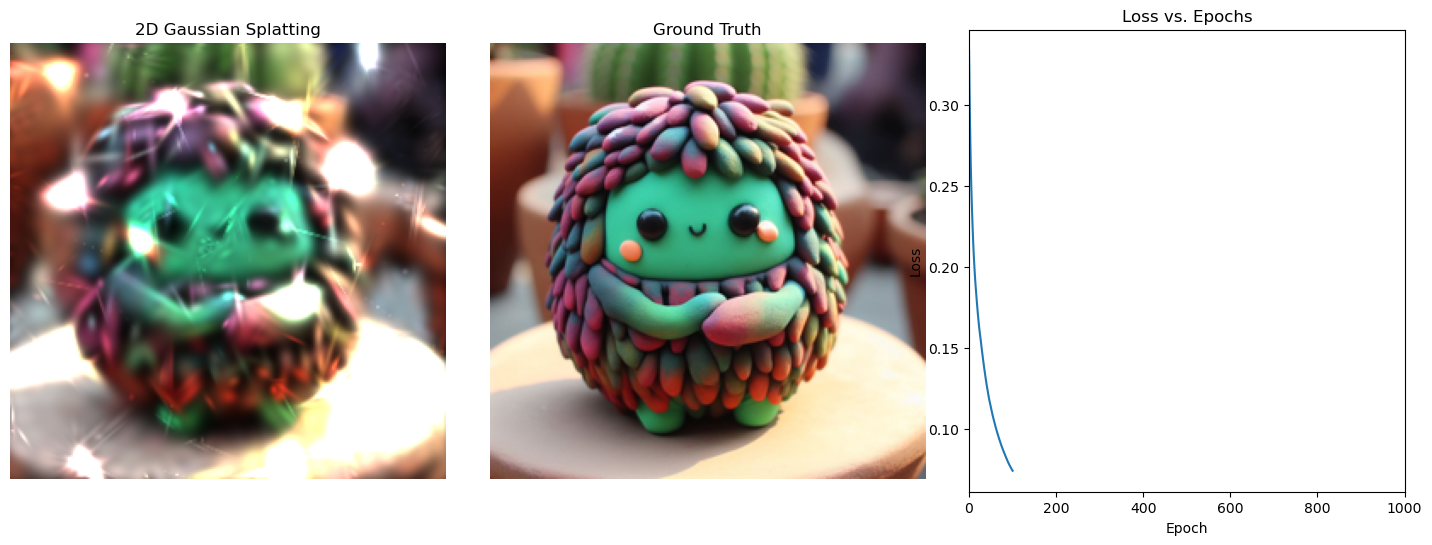

Epoch 101/1001, Loss: 0.07441835105419159, on 1000 points


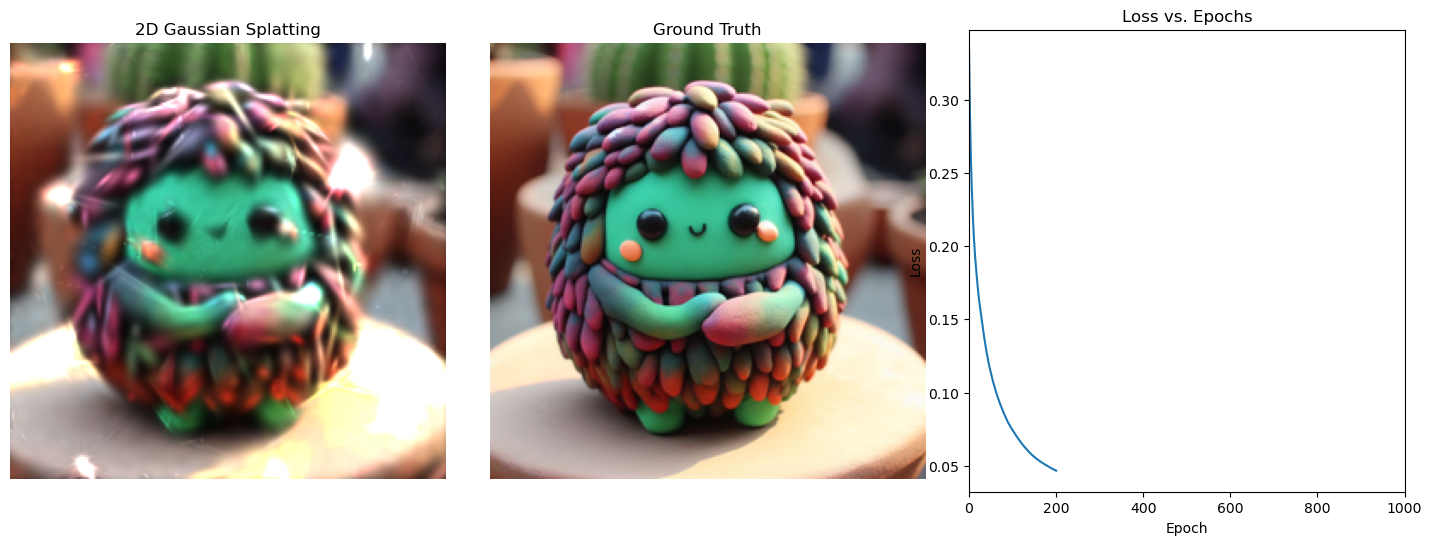

Epoch 201/1001, Loss: 0.04675132781267166, on 1000 points


NameError: name 'grad_threshold' is not defined

In [12]:
for epoch in range(num_epochs):

    #find indices to remove and update the persistent mask
    if epoch % (densification_interval + 1) == 0 and epoch > 0:
        indices_to_remove = (torch.sigmoid(W[:, 3]) < 0.01).nonzero(as_tuple=True)[0]

        if len(indices_to_remove) > 0:
          print(f"number of pruned points: {len(indices_to_remove)}")

        persistent_mask[indices_to_remove] = False

        # Zero-out parameters and their gradients at every epoch using the persistent mask
        W.data[~persistent_mask] = 0.0


    gc.collect()
    torch.cuda.empty_cache()

    output = W[persistent_mask]

    batch_size = output.shape[0]

    scale = torch.sigmoid(output[:, 0:2])
    rotation = np.pi / 2 * torch.tanh(output[:, 2])
    alpha = torch.sigmoid(output[:, 3])
    colours = torch.sigmoid(output[:, 4:7])
    pixel_coords = torch.tanh(output[:, 7:9])

    colours_with_alpha  = colours * alpha.view(batch_size, 1)
    g_tensor_batch = generate_2D_gaussian_splatting(KERNEL_SIZE, scale, rotation, pixel_coords, colours, image_size, device=device)
    loss = combined_loss(g_tensor_batch, target_tensor, lambda_param=0.2)

    optimizer.zero_grad()

    loss.backward()

    # Apply zeroing out of gradients at every epoch
    if persistent_mask is not None:
        W.grad.data[~persistent_mask] = 0.0

    if epoch % densification_interval == 0 and epoch > 0:

      # Calculate the norm of gradients
      gradient_norms = torch.norm(W.grad[persistent_mask][:, 7:9], dim=1, p=2)
      gaussian_norms = torch.norm(torch.sigmoid(W.data[persistent_mask][:, 0:2]), dim=1, p=2)

      sorted_grads, sorted_grads_indices = torch.sort(gradient_norms, descending=True)
      sorted_gauss, sorted_gauss_indices = torch.sort(gaussian_norms, descending=True)

      large_gradient_mask = (sorted_grads > gradient_threshold)
      large_gradient_indices = sorted_grads_indices[large_gradient_mask]

      large_gauss_mask = (sorted_gauss > gaussian_threshold)
      large_gauss_indices = sorted_gauss_indices[large_gauss_mask]

      common_indices_mask = torch.isin(large_gradient_indices, large_gauss_indices)
      common_indices = large_gradient_indices[common_indices_mask]
      distinct_indices = large_gradient_indices[~common_indices_mask]

      # Split points with large coordinate gradient and large gaussian values and descale their gaussian
      if len(common_indices) > 0:
        print(f"Number of splitted points: {len(common_indices)}")
        start_index = current_marker + 1
        end_index = current_marker + 1 + len(common_indices)
        persistent_mask[start_index: end_index] = True
        W.data[start_index:end_index, :] = W.data[common_indices, :]
        scale_reduction_factor = 1.6
        W.data[start_index:end_index, 0:2] /= scale_reduction_factor
        W.data[common_indices, 0:2] /= scale_reduction_factor
        current_marker = current_marker + len(common_indices)

      # Clone it points with large coordinate gradient and small gaussian values
      if len(distinct_indices) > 0:

        print(f"Number of cloned points: {len(distinct_indices)}")
        start_index = current_marker + 1
        end_index = current_marker + 1 + len(distinct_indices)
        persistent_mask[start_index: end_index] = True
        W.data[start_index:end_index, :] = W.data[distinct_indices, :]

        # Calculate the movement direction based on the positional gradient
        positional_gradients = W.grad[distinct_indices, 7:9]
        gradient_magnitudes = torch.norm(positional_gradients, dim=1, keepdim=True)
        normalized_gradients = positional_gradients / (gradient_magnitudes + 1e-8)  # Avoid division by zero

        # Define a step size for the movement
        step_size = 0.01

        # Move the cloned Gaussians
        W.data[start_index:end_index, 7:9] += step_size * normalized_gradients

        current_marker = current_marker + len(distinct_indices)

    optimizer.step()

    loss_history.append(loss.item())

    if epoch % display_interval == 0:
        num_subplots = 3 if display_loss else 2
        fig_size_width = 18 if display_loss else 12

        fig, ax = plt.subplots(1, num_subplots, figsize=(fig_size_width, 6))  # Adjust subplot to 1x3

        generated_array = g_tensor_batch.cpu().detach().numpy()

        ax[0].imshow(g_tensor_batch.cpu().detach().numpy())
        ax[0].set_title('2D Gaussian Splatting')
        ax[0].axis('off')

        ax[1].imshow(target_tensor.cpu().detach().numpy())
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')

        if display_loss:
          ax[2].plot(range(epoch + 1), loss_history[:epoch + 1])
          ax[2].set_title('Loss vs. Epochs')
          ax[2].set_xlabel('Epoch')
          ax[2].set_ylabel('Loss')
          ax[2].set_xlim(0, num_epochs)  # Set x-axis limits

        # Display the image
        #plt.show(block=False)
        plt.subplots_adjust(wspace=0.1)  # Adjust this value to your preference
        plt.pause(0.1)  # Brief pause

        img = Image.fromarray((generated_array * 255).astype(np.uint8))

        plt.clf()  # Clear the current figure
        plt.close()  # Close the current figure

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, on {len(output)} points")

